# **Data Cleaning**

In [47]:
import pandas as pd
file_path = r'C:\Users\natha\DSCI\data\call_data_from_CAD.csv'
CAD_data = pd.read_csv(file_path)

In [48]:
# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"
CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['PrimaryUnitCallSign'] == 'CAHOOT') | (CAD_data['RespondingUnitCallSign'] == 'CAHOOT')).astype(int)

# Convert dt
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["Call_First_Dispatched_Time"] = pd.to_datetime(CAD_data['Call_First_Dispatched_Time'], errors='coerce')
CAD_data["Unit_OnScene_Time"] = pd.to_datetime(CAD_data['Unit_OnScene_Time'], errors='coerce')

CAD_data["year"] = CAD_data["Call_Created_Time"].dt.year

# Drop unneeded cols
CAD_data = CAD_data.drop(columns=['Unnamed: 0', 'Beat', 'Unit_Cleared_Time'])


In [49]:
# Drop non-public CFS
CAD_data = CAD_data[CAD_data["Call_Source"] != "SELF"]
CAD_data = CAD_data[CAD_data["Call_Source"] != "RPTO"]

# Drop duplicates and NA
#CAD_data = CAD_data.drop_duplicates(subset='IncidentNumber', keep='first')
CAD_data = CAD_data.drop_duplicates()
CAD_data = CAD_data.dropna(subset=["PrimaryUnitCallSign", "RespondingUnitCallSign"], how='all')

# Only include calls in Eugene 
zip_codes = [97402.0, 97401.0, 97405.0, 97404.0, 97403.0, 97408.0]
CAD_data = CAD_data[CAD_data['Call_Zipcode'].isin(zip_codes)]

# Remove 2022 and 2023 until data errors can be fixed
CAD_data = CAD_data[~CAD_data["year"].isin([2022, 2023])]

In [50]:
def filter_df_by_time(df, start_time=None, end_time=None, time_column='Call_Created_Time'):
    """
    Filters the dataframe based on the time range specified by the user

    Parameters:
    df to filter
    start_time (str)
    end_time (str)
    time_column (str): The name of the column containing datetime values

    """
    df.loc[:, time_column] = pd.to_datetime(df[time_column])

    if start_time:
        if len(start_time) == 4:  # if only a year is given
            start_time = pd.to_datetime(f"{start_time}-01-01")
    else:
        start_time = df[time_column].min() 

    if end_time:
        if len(end_time) == 4:  
            end_time = pd.to_datetime(f"{end_time}-12-31 23:59:59")
    else:
        end_time = df[time_column].max()  

    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

    return filtered_df

In [51]:
def dataset_builder(data, dispatched=False, arrived=False, solo_cahoots=False, time=None):
    """
    Parameters:
    time (list of strings) [start time, end time, time_col]
    
    """
    # Apply time range if specified
    if time:
        data = filter_df_by_time(data, time[0], time[1], time[2])
    
    # Dispatched filter is based on "Unit_Dispatched_Time"
    if dispatched:
        data = data[data["Unit_Dispatched_Time"].notna()]
    
    # Arrived filter is based on "Call_First_Dispatched_Time"
    if arrived:
        data = data[data["Unit_OnScene_Time"].notna()]
        data = data[data["Unit_Dispatched_Time"].notna()]
        
    # Only Include CAHOOTS calls where no other agencies are involved
    if solo_cahoots:
        data = data[~((data['PrimaryUnitCallSign'] == 'CAHOOTS') & (data['IsPrimary'] == 0))]
        
    return data

#dataset_builder(CAD_data, dispatched=False, arrived=False, solo_cahoots= False, time=['2021', '2021', 'Call_Created_Time'])["InitialIncidentTypeDescription"].value_counts()

## **The Overlapping Mandate**

In [52]:
def common_types(dataset, col):
    # Create subsets for Cahoots-related and police-handled incidents
    cahoots_related = dataset[dataset["Cahoots_related"] == 1]
    police_handled = dataset[dataset["Cahoots_related"] == 0]
    
    # Determine overlapping incident types
    cahoots_types = set(cahoots_related[col].unique())
    police_types = set(police_handled[col].unique())
    common_types = list(cahoots_types.intersection(police_types))
    
    return common_types


def prop_table(dataset):
    # Get common incident types between Cahoots and police-handled incidents
    type_list = common_types(dataset=dataset, col="InitialIncidentTypeDescription")
    
    # Filter datasets based on these common incident types
    cahoots_related = dataset[(dataset["Cahoots_related"] == 1) & (dataset["InitialIncidentTypeDescription"].isin(type_list))]
    police_handled = dataset[(dataset["Cahoots_related"] == 0) & (dataset["InitialIncidentTypeDescription"].isin(type_list))]
    
    # Calculate incident counts for each type
    cahoots_counts = cahoots_related["InitialIncidentTypeDescription"].value_counts()
    police_counts = police_handled["InitialIncidentTypeDescription"].value_counts()
    
    # Merge the two counts on the incident types to ensure alignment
    merged_counts = cahoots_counts.to_frame(name="cahoots_count").join(police_counts.to_frame(name="police_count"), how="inner")
    
    # Calculate the proportion of incidents handled by Cahoots for each type
    merged_counts["prop_cahoots"] = merged_counts["cahoots_count"] / (merged_counts["cahoots_count"] + merged_counts["police_count"])
    
    # Create the final DataFrame and sort by the proportion
    final_df = merged_counts.reset_index().rename(columns={"index": "InitialIncidentTypeDescription"})
    final_df = final_df.sort_values(by="prop_cahoots", ascending=False)
    
    return final_df


def simple_overlap_data(data, lower_threshold, upper_threshold):
    if lower_threshold > upper_threshold:
        raise ValueError("ERROR: Lower threshold cannot be greater than upper threshold")
    
    # Generate the proportion table
    comparison_table = prop_table(data)
    
    # Filter the table based on the thresholds
    filtered_calls_table = comparison_table[
        (comparison_table["prop_cahoots"] > lower_threshold) & 
        (comparison_table["prop_cahoots"] < upper_threshold)
    ]
    filtered_calls_list = filtered_calls_table["InitialIncidentTypeDescription"].tolist()
    
    # Return data for incident types that fall within the thresholds
    overlap_data = data[data["InitialIncidentTypeDescription"].isin(filtered_calls_list)]
    
    return overlap_data


def calculate_diversions(data, by_year=True):
    # Split the data into Cahoots-related and police-handled subsets
    cahoots_related = data[data["Cahoots_related"] == 1]
    police_handled = data[data["Cahoots_related"] == 0]
    
    if by_year:
        # Calculate diversions by year
        cahoots_year = cahoots_related.groupby("year").size()
        epd_year = police_handled.groupby("year").size()
        total_year = cahoots_year + epd_year
        diversions_by_year = (cahoots_year / total_year) * 100
        return diversions_by_year.reset_index().rename(columns={0: 'Diversion Rate'})
    else:
        # Calculate overall diversion rate
        diversion_rate = (len(cahoots_related) / (len(police_handled) + len(cahoots_related))) * 100
        return diversion_rate

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [54]:
import matplotlib.pyplot as plt

def plot_diversion_rate_vs_threshold(data, initial_lower=0.0, initial_upper=1.0, step=0.02):
    diversion_rates = []
    thresholds = []

    lower_threshold = initial_lower
    upper_threshold = initial_upper

    # Continue adjusting thresholds until the range is no longer valid
    while lower_threshold < upper_threshold:
        div_data = simple_overlap_data(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
        diversion_rate = calculate_diversions(div_data, by_year=False)
        diversion_rates.append(diversion_rate)
        thresholds.append((lower_threshold, upper_threshold))

        # Increment the thresholds
        lower_threshold += step
        upper_threshold -= step

    plt.figure(figsize=(10, 6))
    threshold_labels = [f'{lt:.2f}-{ut:.2f}' for lt, ut in thresholds]
    plt.plot(threshold_labels, diversion_rates, marker='o')
    plt.title('Impact of Incremental Thresholds on Diversion Rate')
    plt.xlabel('Thresholds (Lower-Upper)')
    plt.ylabel('Diversion Rate (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

#plot_diversion_rate_vs_threshold(dataset_builder(CAD_data, dispatched=True, arrived=True, time=['2016', '2021', 'Call_Created_Time']),initial_lower=0.0, initial_upper=1.0, step=0.02)

In [55]:
import matplotlib.pyplot as plt
import squarify
import numpy as np
import pandas as pd
import hashlib

target = 'InitialIncidentTypeDescription'

def process_data(data, top_n, group_others, target):
    value_counts = data[target].value_counts()
    total = value_counts.sum()
    if group_others:
        top_categories = value_counts.nlargest(top_n)
        other_sum = value_counts.iloc[top_n:].sum()
        if other_sum > 0:
            top_categories['Other'] = other_sum
    else:
        top_categories = value_counts.nlargest(top_n)
    return top_categories, total

def hash_to_index(text, num_colors):
    # Generate a hash for the text and map it to an index
    hash_val = int(hashlib.sha256(text.encode('utf-8')).hexdigest(), 16)
    return hash_val % num_colors

def create_treemap(data, title, top_n, group_others, max_legend_entries, show_labels, color_list, min_label_area_ratio=0.005):
    num_colors = len(color_list)
    top_data, total = process_data(data, top_n, group_others, target)
    
    color_map = {}
    assigned_colors = set()
    for label in top_data.index:
        index = hash_to_index(label, num_colors)
        original_index = index  
        while color_list[index] in assigned_colors:
            index = (index + 1) % num_colors
            if index == original_index:
                break  
        color_map[label] = color_list[index]
        assigned_colors.add(color_list[index])
    
    fig, ax = plt.subplots(figsize=(15, 6))
    sizes = top_data.values
    colors = [color_map[label] if label in color_map else '#CCCCCC' for label in top_data.index]  # Default color for 'Other'
    labels = [f"{incident}\n({value / total * 100:.1f}%)" for incident, value in top_data.items()]
    
    squarify.plot(sizes=sizes, label=["" for _ in sizes], color=colors, alpha=0.8, pad=False, ec='black', text_kwargs={'fontsize': 'smaller'})
    plt.title(title)
    plt.axis('off')

    total_area = sum([rect.get_width() * rect.get_height() for rect in ax.patches])
    for text, rect in zip(labels, ax.patches):
        # Only show label if the area of the box is greater than a certain percentage of the total area
        area_ratio = (rect.get_width() * rect.get_height()) / total_area
        if area_ratio > min_label_area_ratio:
            ax.text(rect.get_x() + rect.get_width()/2, rect.get_y() + rect.get_height()/2, text, ha='center', va='center', fontsize=max(6, min(16, area_ratio * total_area / 100)))

    # Legend
    patches = [plt.Rectangle((0, 0), 1, 1, facecolor=color_map[incident]) for incident in top_data.index]
    legend_labels = [f"{incident} ({value / total * 100:.2f}%)" for incident, value in top_data.items()]
    #plt.legend(patches, legend_labels[:max_legend_entries], loc='upper left', bbox_to_anchor=(1, 1), title="Incident Types")

    plt.show()


In [56]:
def create_treemap_adv(data, title, top_n, group_others, color_list, min_label_area_ratio=0.005):
    num_colors = len(color_list)
    
    # Ensure the 'total' column is correctly computed
    data["total"] = data["cahoots_count"] + data["police_count"]
    
    # Sort data by 'total' in descending order
    sorted_data = data.sort_values(by="total", ascending=False)
    
    # Extract proportions of CAHOOTS involvement
    cahoots_proportions = sorted_data["prop_cahoots"]
    
    # Group others if specified
    if group_others:
        top_categories = sorted_data.iloc[:top_n].copy()
        other_sum = sorted_data.iloc[top_n:]["total"].sum()
        other_cahoots_prop = sorted_data.iloc[top_n:]["prop_cahoots"].mean()  # Mean CAHOOTS proportion for 'Other'
        
        # Create an 'Other' category if needed
        if other_sum > 0:
            other_row = pd.DataFrame({
                'InitialIncidentTypeDescription': ['Other'],
                'total': [other_sum],
                'prop_cahoots': [other_cahoots_prop]
            })
            top_categories = pd.concat([top_categories, other_row], ignore_index=True)
    
    else:
        top_categories = sorted_data.iloc[:top_n]

    # Assign a color to each category
    color_map = {}
    assigned_colors = set()
    for idx, row in top_categories.iterrows():
        label = row['InitialIncidentTypeDescription']
        index = hash(label) % num_colors  # Assign a color based on hashing
        original_index = index  
        while color_list[index] in assigned_colors:
            index = (index + 1) % num_colors
            if index == original_index:
                break  
        color_map[label] = color_list[index]
        assigned_colors.add(color_list[index])
    
    # Setup the figure and axes for plotting
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Prepare the data for plotting
    sizes = top_categories["total"].values
    colors = [color_map[label] for label in top_categories["InitialIncidentTypeDescription"]]
    total_sum = top_categories["total"].sum()
    labels = [f"{incident}\n({value / total_sum * 100:.1f}%)" for incident, value in zip(top_categories["InitialIncidentTypeDescription"], sizes)]
    
    # Plot the treemap
    squarify.plot(sizes=sizes, label=["" for _ in sizes], color=colors, alpha=0.8, pad=False, ax=ax, ec='black', text_kwargs={'fontsize': 'smaller'})
    plt.title(title)
    plt.axis('off')

    total_area = sum([rect.get_width() * rect.get_height() for rect in ax.patches])
    
    # Add labels and hatches for CAHOOTS proportions
    for text, rect, label in zip(labels, ax.patches, top_categories["InitialIncidentTypeDescription"]):
        area_ratio = (rect.get_width() * rect.get_height()) / total_area
        if area_ratio > min_label_area_ratio:
            # Create the text object to get its size
            text_obj = ax.text(0, 0, text, fontsize=max(6, min(16, area_ratio * total_area / 100)), ha='center', va='center')
            text_bb = text_obj.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transData.inverted())

            # Increase padding around the text to make the boxes slightly larger
            padding = 1  # Increase padding for larger boxes
            text_width = text_bb.width + padding
            text_height = text_bb.height + padding

            # Remove the temporary text object (we'll recreate it with proper coordinates)
            text_obj.remove()

            # Draw a solid rectangle behind the label for readability
            text_rect = plt.Rectangle(
                (rect.get_x() + rect.get_width() / 2 - text_width / 2, rect.get_y() + rect.get_height() / 2 - text_height / 2),
                text_width,
                text_height,
                facecolor='white',  # Background color (solid)
                edgecolor='black',
                alpha=1,  # Adjust transparency for better visual
                zorder=2  # Ensure it appears below the text
            )
            ax.add_patch(text_rect)
            
            # Draw the label over the solid background rectangle
            ax.text(rect.get_x() + rect.get_width()/2, rect.get_y() + rect.get_height()/2, text, ha='center', va='center', fontsize=max(6, min(16, area_ratio * total_area / 100)), zorder=3)

        # Overlay CAHOOTS proportion with hatches
        cahoots_prop = top_categories.loc[top_categories["InitialIncidentTypeDescription"] == label, "prop_cahoots"].values[0]
        cahoots_width = rect.get_width() * cahoots_prop
        hatch_rect = plt.Rectangle(
            (rect.get_x(), rect.get_y()), 
            cahoots_width, 
            rect.get_height(), 
            hatch='xxxx',  # You can replace this with other patterns as desired
            facecolor='none', 
            edgecolor='black', 
            lw=0,
            zorder=1  # Ensure it appears beneath the label
        )
        ax.add_patch(hatch_rect)

    plt.show()

In [57]:
import seaborn as sns
colors = sns.color_palette("pastel")
#create_treemap(dataset_builder(CAD_data, dispatched=True, arrived=True, time=['2016', '2021', 'Call_Created_Time']), 'Top 10 Cahoots Call Types', top_n=10, group_others=True, max_legend_entries=10, show_labels=True, color_list=colors, min_label_area_ratio=0.01)

In [58]:
import matplotlib.pyplot as plt

def plot_diversion_by_year(df, lower_threshold, upper_threshold):
    years = df['year'].tolist()
    cahoots_percentage = df['Diversion Rate'].tolist()
    epd_percentage = [100 - val for val in cahoots_percentage]

    plt.figure(figsize=(10, 6))
    plt.bar(years, epd_percentage, label='EPD', color='lightblue')
    plt.bar(years, cahoots_percentage, bottom=epd_percentage, label='Cahoots', color='orange')

    # Labels and title 
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Diversion Rate (%)', fontsize=12, fontweight='bold')
    plt.title(f"Yearly Diversions of Overlapping Mandate\n(Thresholds: {lower_threshold} < prop_cahoots < {upper_threshold})", 
              fontsize=16, fontweight='bold', pad=20)

    # Removing spines 
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Data labels 
    for i in range(len(years)):
        plt.text(years[i], epd_percentage[i] + cahoots_percentage[i] / 2, f'{cahoots_percentage[i]:.1f}%', 
                 ha='center', va='center', color='black')

    plt.legend(['EPD', 'Cahoots'], loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# **Yearly Diversions of Overlapping Mandate**

In [59]:
Dispatched = True
Arrived = True
time_range = ['2016', '2021', 'Call_Created_Time']

THRESHOLD_high = 0.85
THRESHOLD_low = 0.15

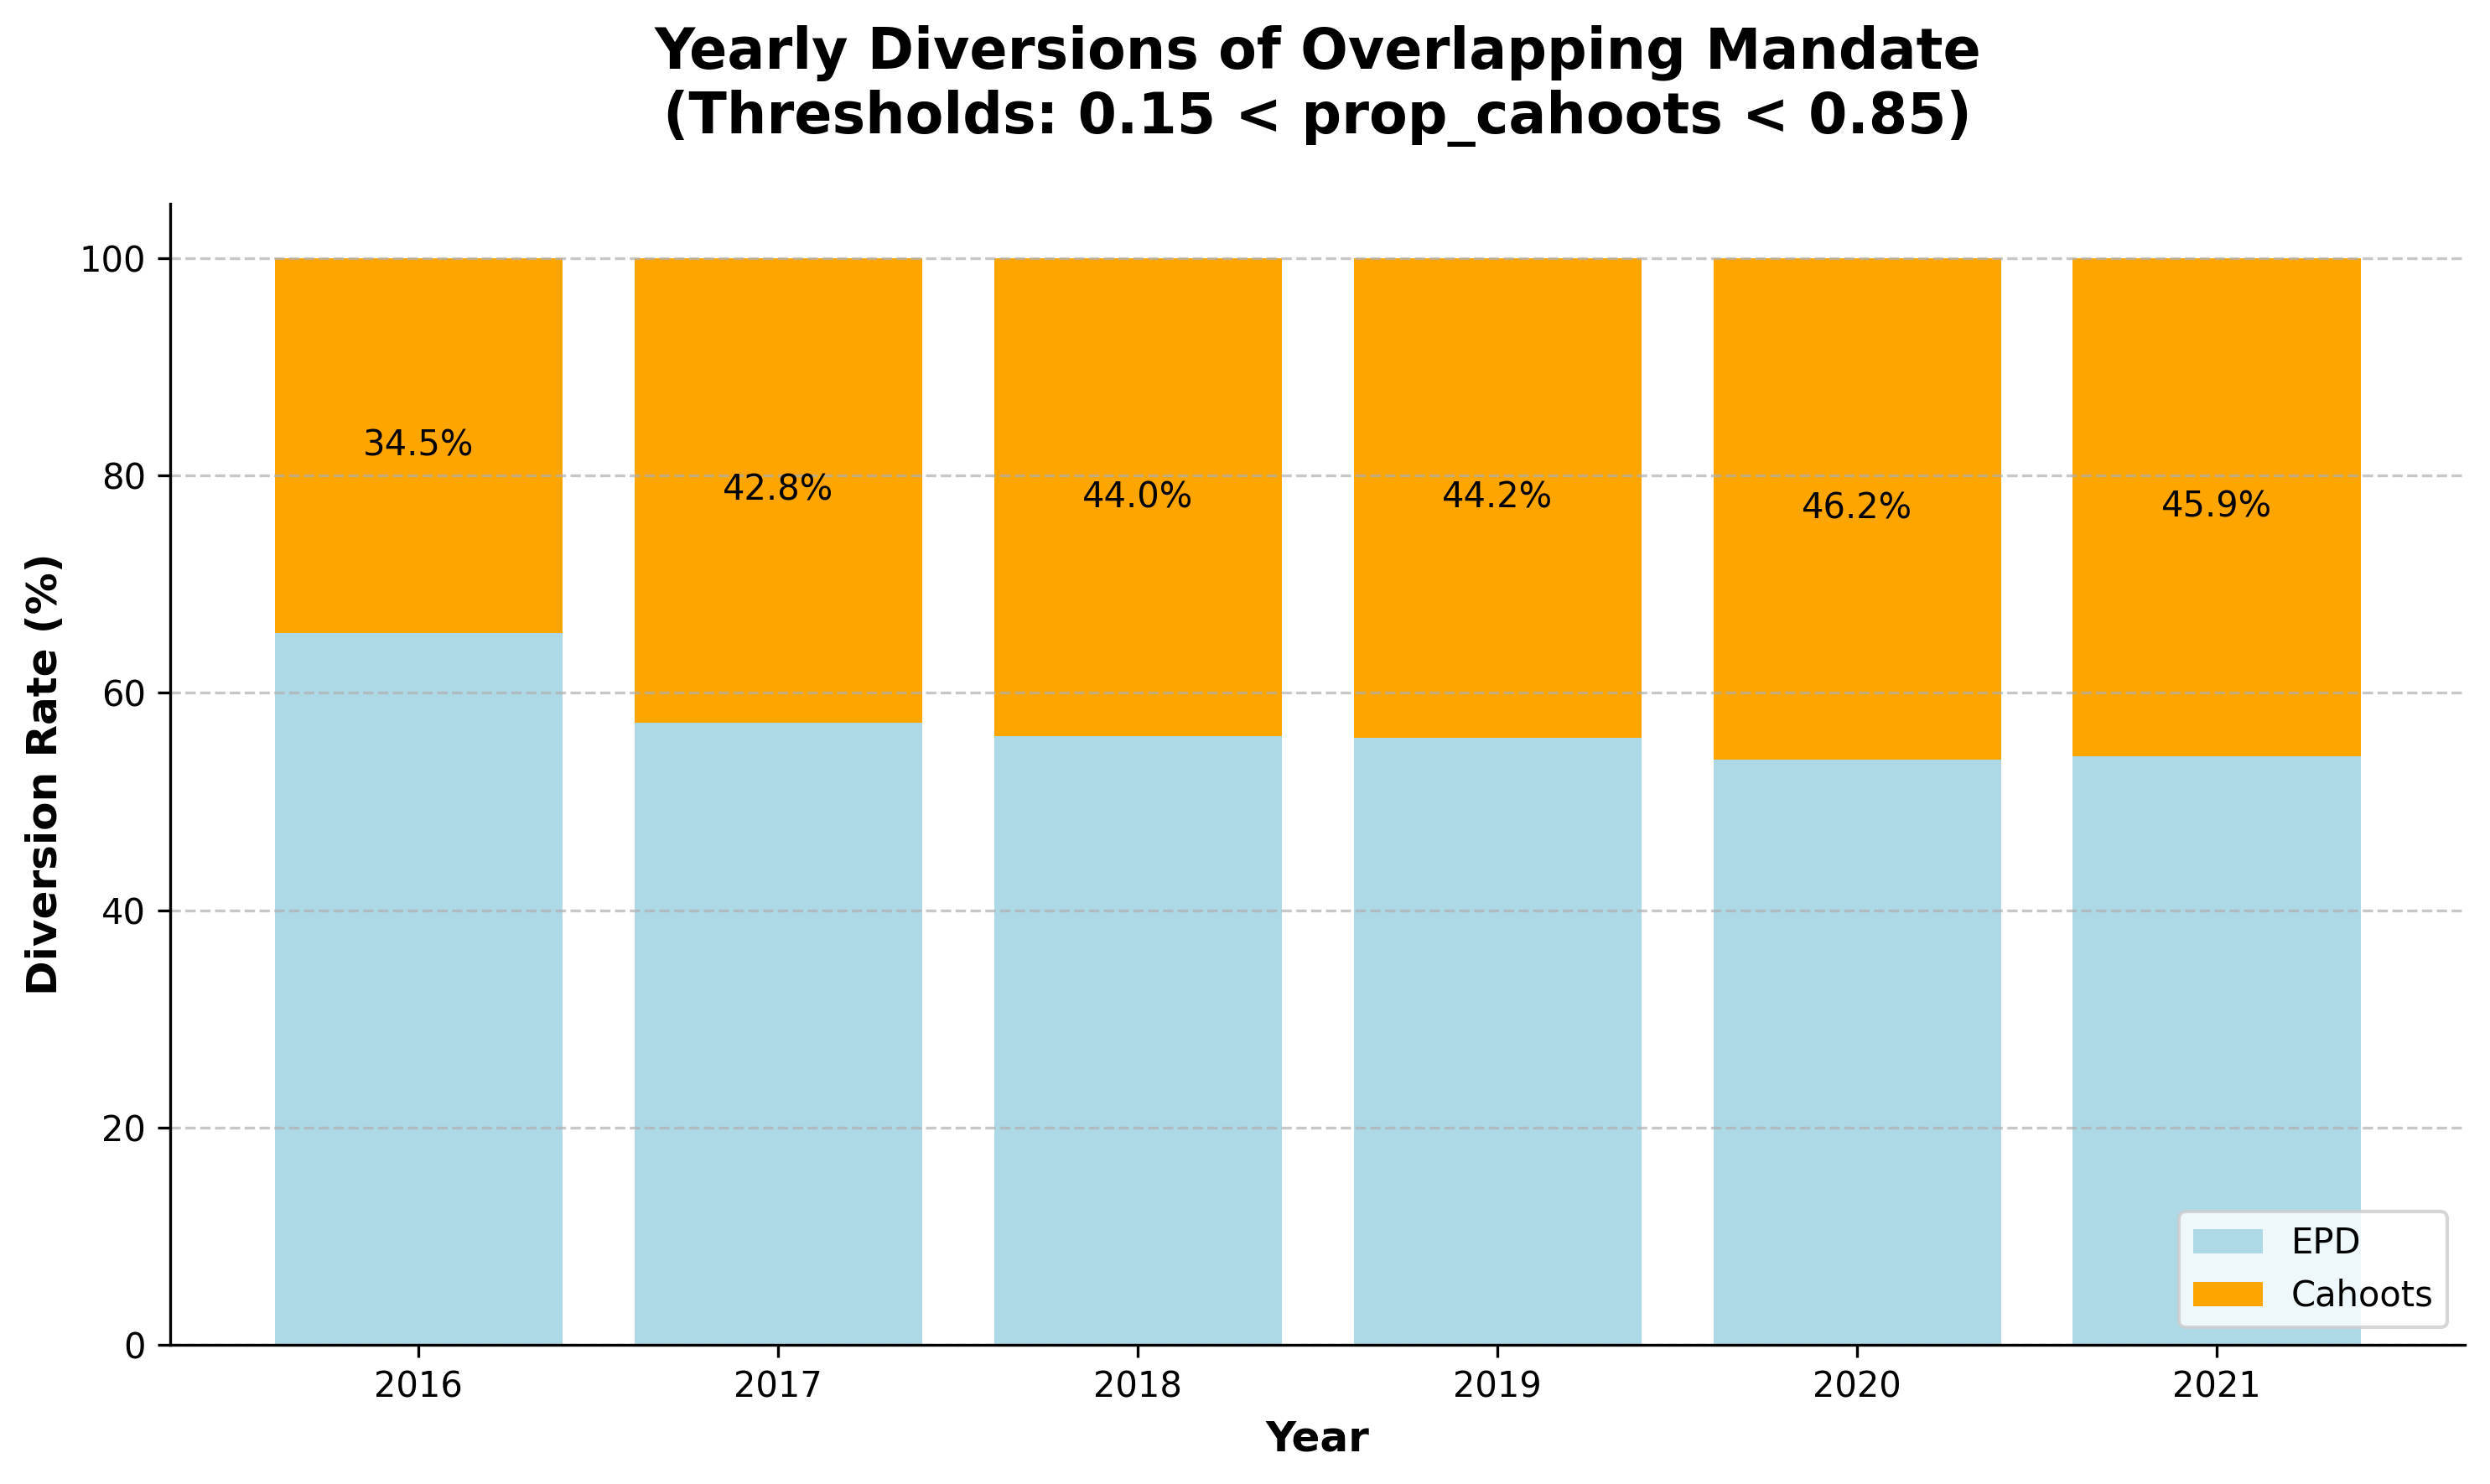

In [60]:
filtered_data = dataset_builder(CAD_data, dispatched=Dispatched, arrived=Arrived, time=time_range)
diversion_rates_by_year = calculate_diversions(simple_overlap_data(filtered_data, THRESHOLD_low, THRESHOLD_high), by_year=True)
plot_diversion_by_year(diversion_rates_by_year, THRESHOLD_low, THRESHOLD_high)
plt.show()

In [61]:
overlap_table = prop_table(simple_overlap_data(filtered_data, THRESHOLD_low, THRESHOLD_high))
overlap_table

,InitialIncidentTypeDescription,cahoots_count,police_count,prop_cahoots
11,EMERGENCY MESSAGE,68,28,0.708333
4,FOUND SYRINGE,1312,552,0.703863
9,DEATH MESSAGE,117,68,0.632432
6,DISORIENTED SUBJECT,619,429,0.590649
2,INTOXICATED SUBJECT,1832,1400,0.566832
0,CHECK WELFARE,27945,28630,0.493946
13,POISONING,20,22,0.476190
16,DETOXIFICATION,3,4,0.428571
1,SUICIDAL SUBJECT,7621,11045,0.408282
5,ASSIST FIRE DEPARTMENT,943,2325,0.288556


# **Diversions of Overlapping Mandate and Threshold**

In [62]:
Dispatched = True
Arrived = True
time_range = ['2016', '2021', 'Call_Created_Time']

initial_lower=0.0 
initial_upper=1.0
step=0.02

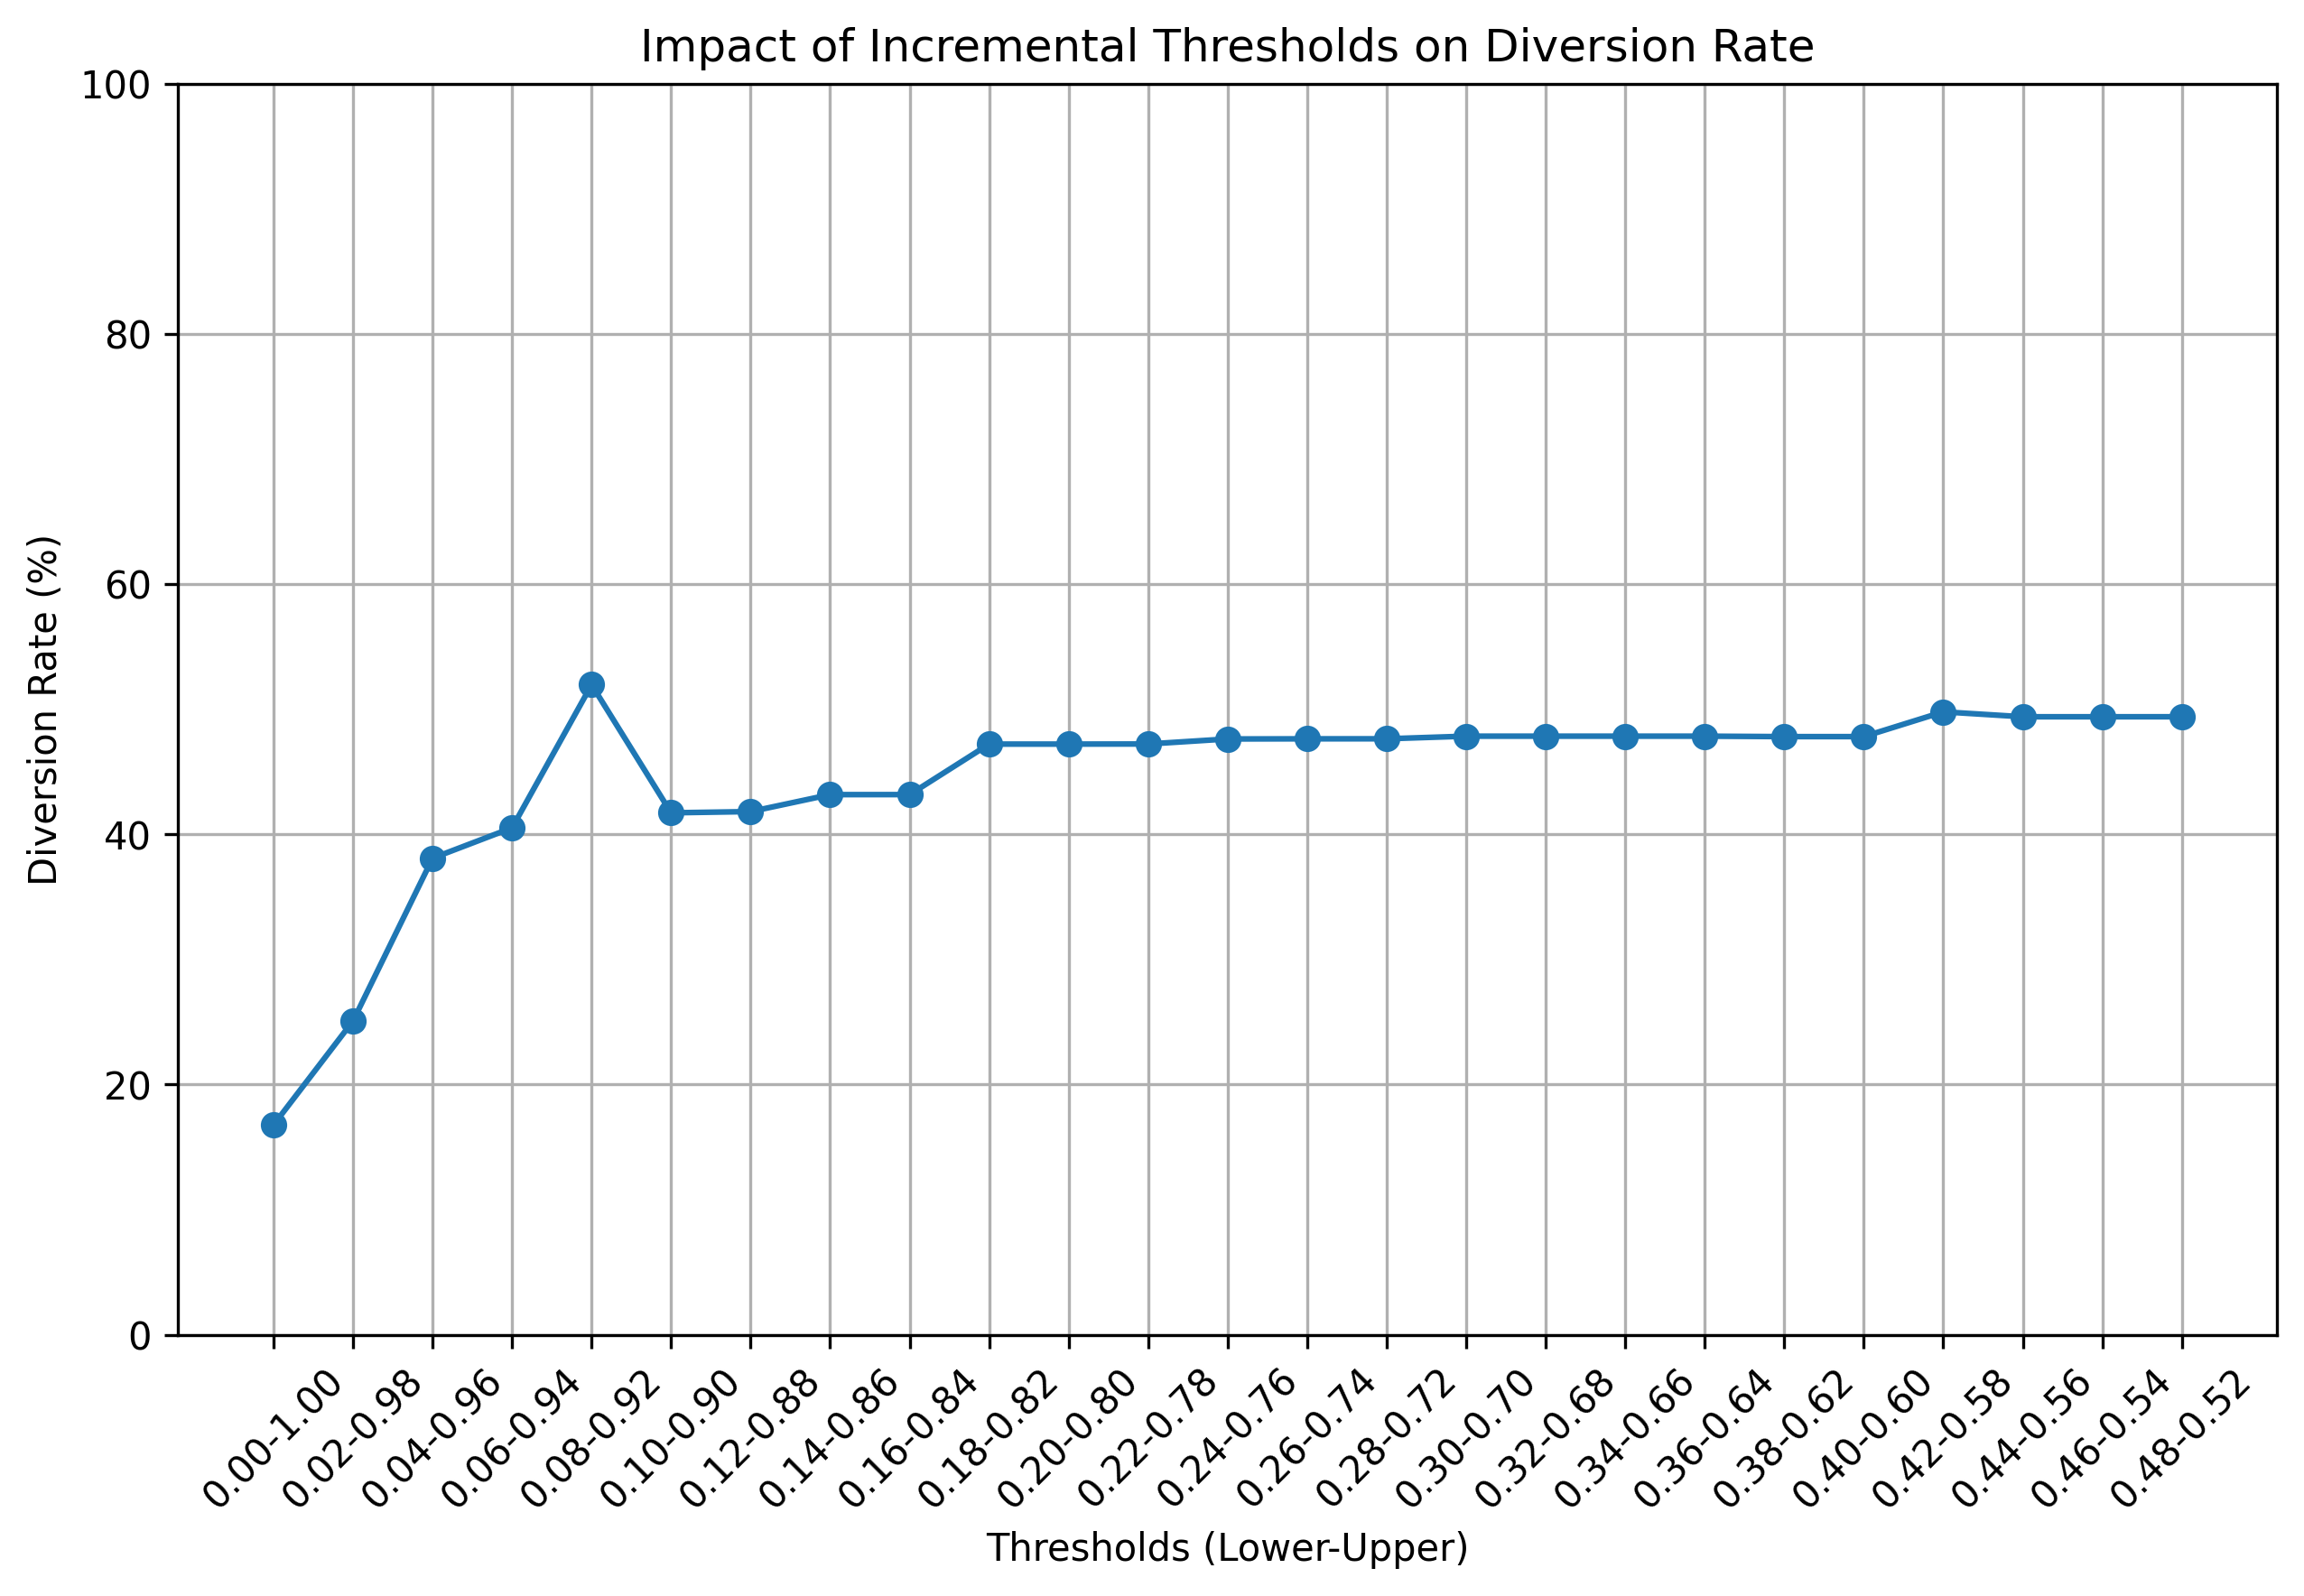

In [63]:
plot_diversion_rate_vs_threshold(dataset_builder(CAD_data, dispatched=Dispatched, arrived=Arrived, time=time_range),initial_lower=initial_lower, initial_upper=initial_upper, step=step)

In [64]:
# Notes
# Incremental impact of threshold on number of Incidents included

# Diversions of overlapping mandate by incident 

# **Tree Maps**

In [65]:
# Data Filters
Dispatched = True
Arrived = True
time_range = ['2016', '2021', 'Call_Created_Time']

# Customize Tree map
colors = sns.color_palette("pastel")
Title = "Top 14 CFS Call types"
top_n_types = 14
group_others = True
show_labels = True

# Dataset options
Total_data = CAD_data
Cahoots_data = Total_data[Total_data["Cahoots_related"] == 1]
EPD_data = Total_data[Total_data["Cahoots_related"] == 0]

input_data = Total_data

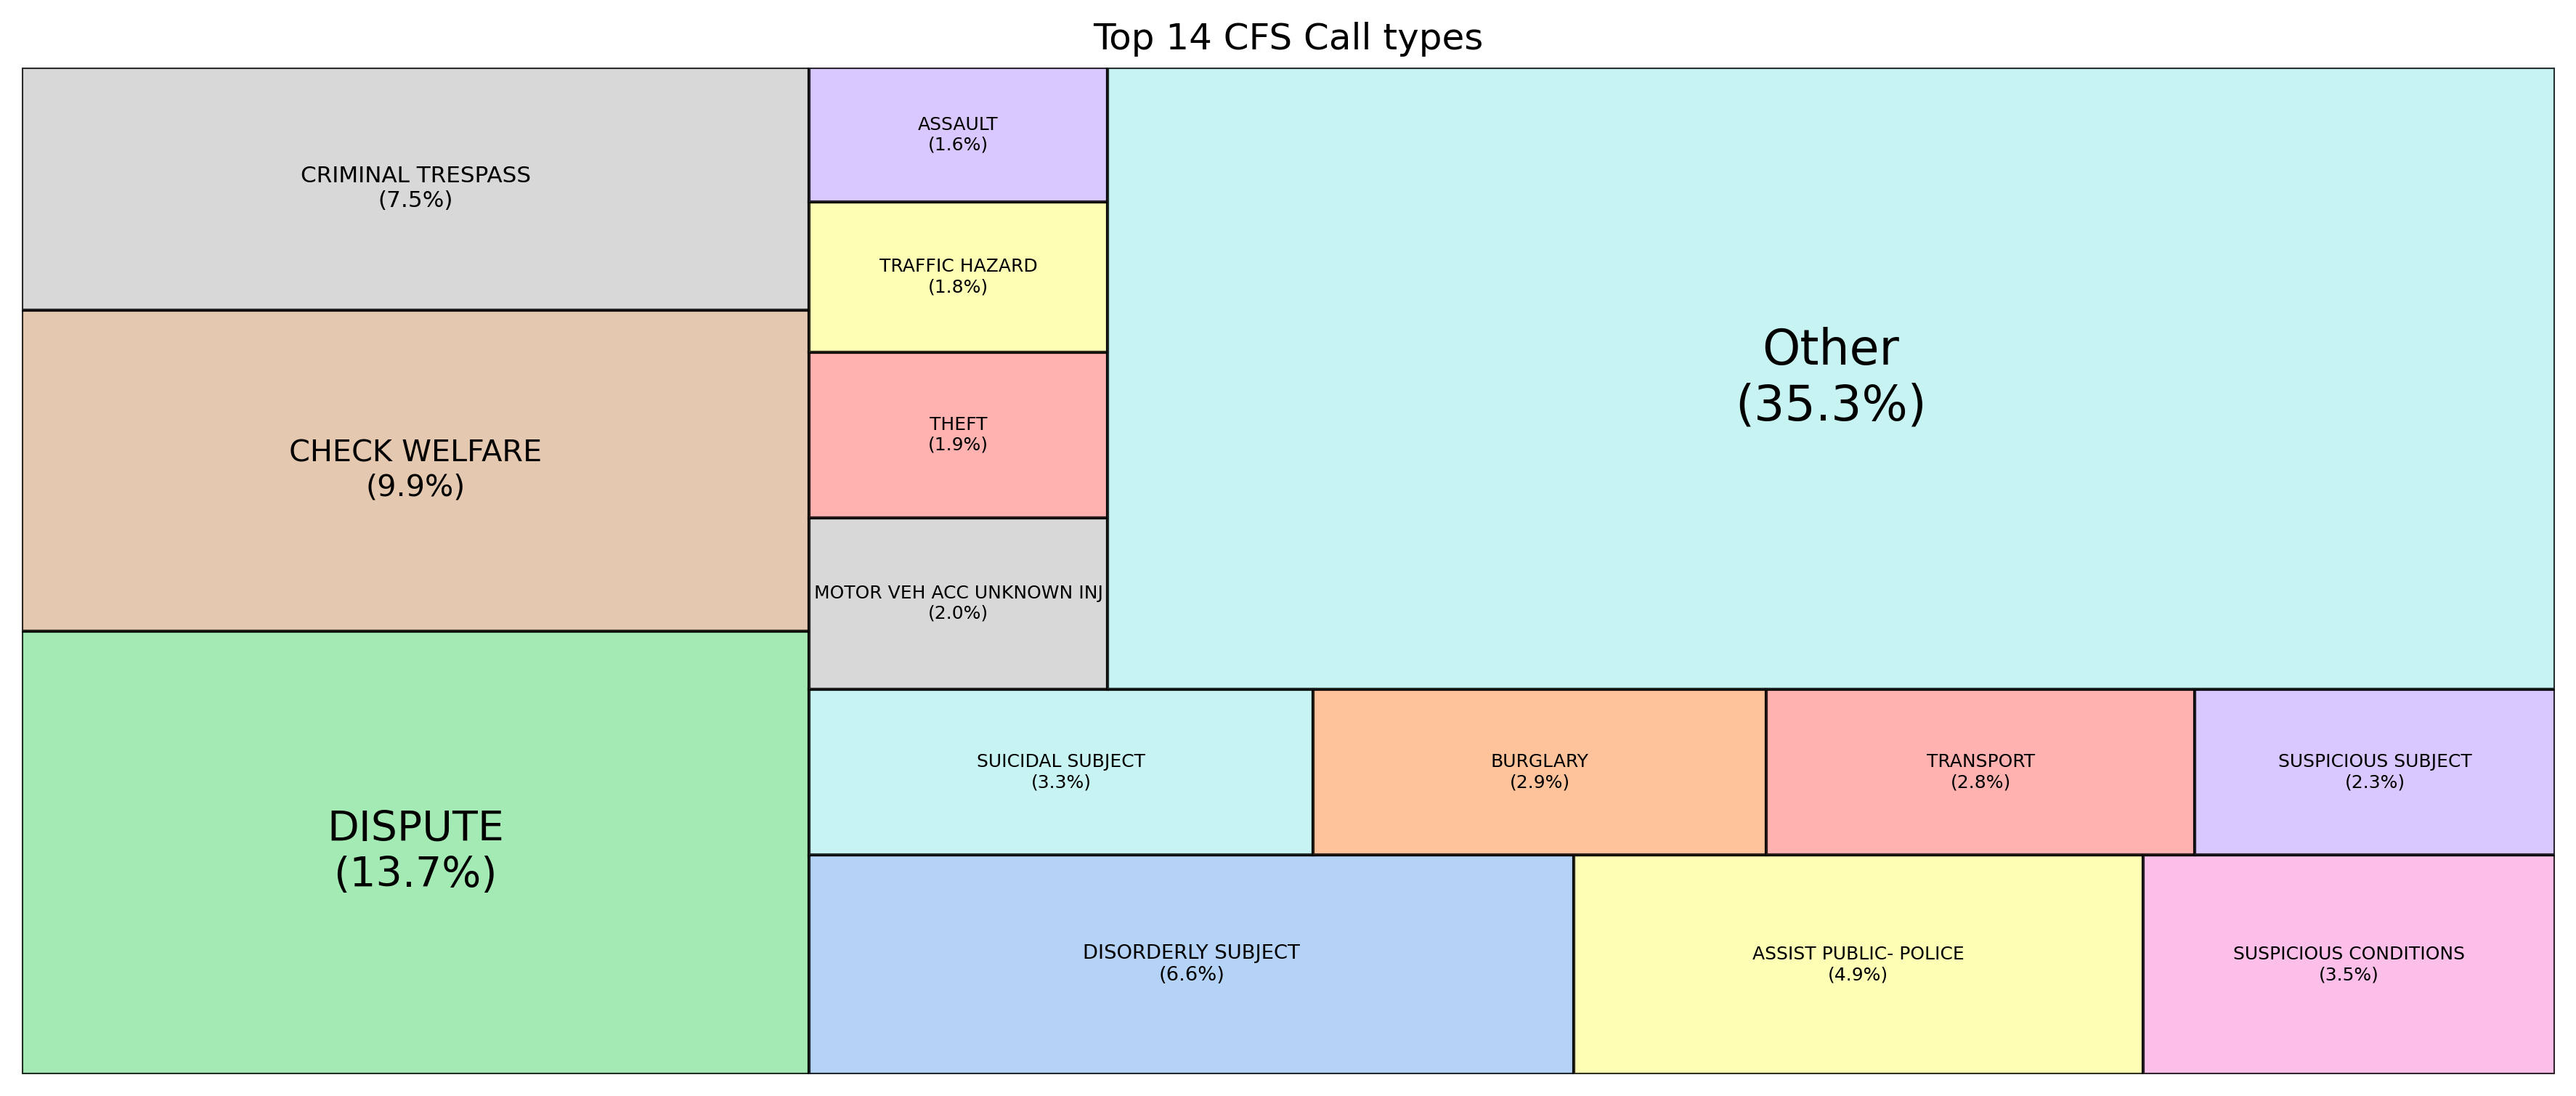

In [66]:
colors = sns.color_palette("pastel")
create_treemap(dataset_builder(input_data, dispatched=Dispatched, arrived=Arrived, time=time_range), Title, top_n=top_n_types, group_others=group_others, max_legend_entries=10, show_labels=show_labels, color_list=colors, min_label_area_ratio=0.01)

In [67]:
# Data Filters
Dispatched = True
Arrived = True
time_range = ['2016', '2021', 'Call_Created_Time']

# Customize Tree map
colors = sns.color_palette("pastel")
Title = "Top 8 CAHOOTS CFS Call types"
top_n_types = 8
group_others = True
show_labels = True

# Dataset options
Total_data = CAD_data
Cahoots_data = Total_data[Total_data["Cahoots_related"] == 1]
EPD_data = Total_data[Total_data["Cahoots_related"] == 0]

input_data = Cahoots_data

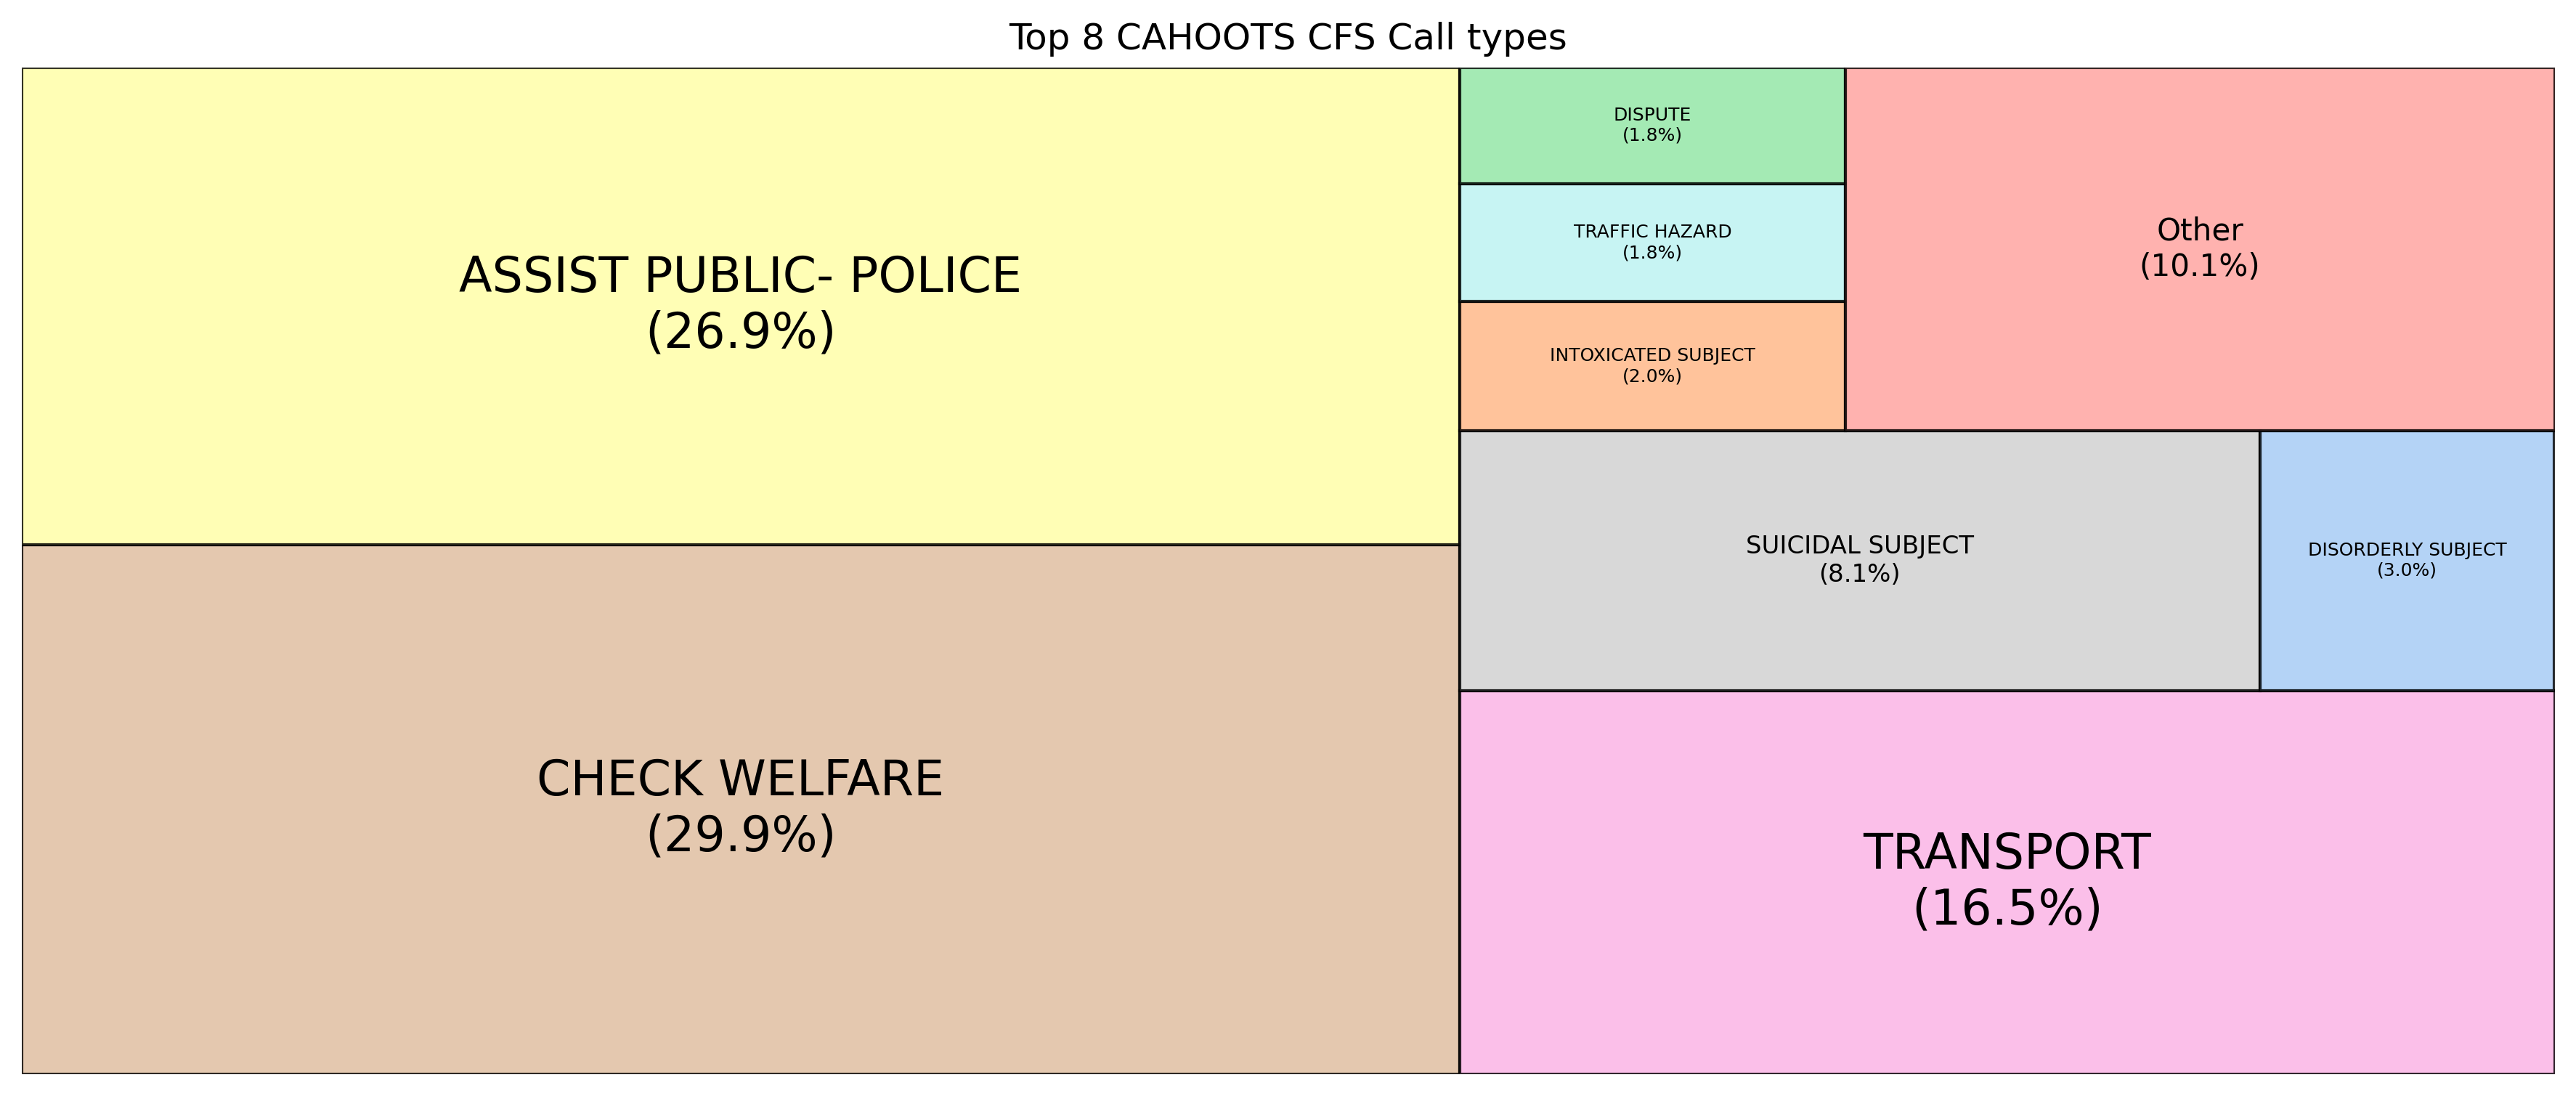

In [68]:
colors = sns.color_palette("pastel")
create_treemap(dataset_builder(input_data, dispatched=Dispatched, arrived=Arrived, time=time_range), Title, top_n=top_n_types, group_others=group_others, max_legend_entries=10, show_labels=show_labels, color_list=colors, min_label_area_ratio=0.01)

In [69]:
# Data Filters
Dispatched = True
Arrived = True
time_range = ['2016', '2021', 'Call_Created_Time']

# Customize Tree map
colors = sns.color_palette("pastel")
Title = "Top 8 EPD CFS Call types"
top_n_types = 8
group_others = True
show_labels = True

# Dataset options
Total_data = CAD_data
Cahoots_data = Total_data[Total_data["Cahoots_related"] == 1]
EPD_data = Total_data[Total_data["Cahoots_related"] == 0]

input_data = EPD_data

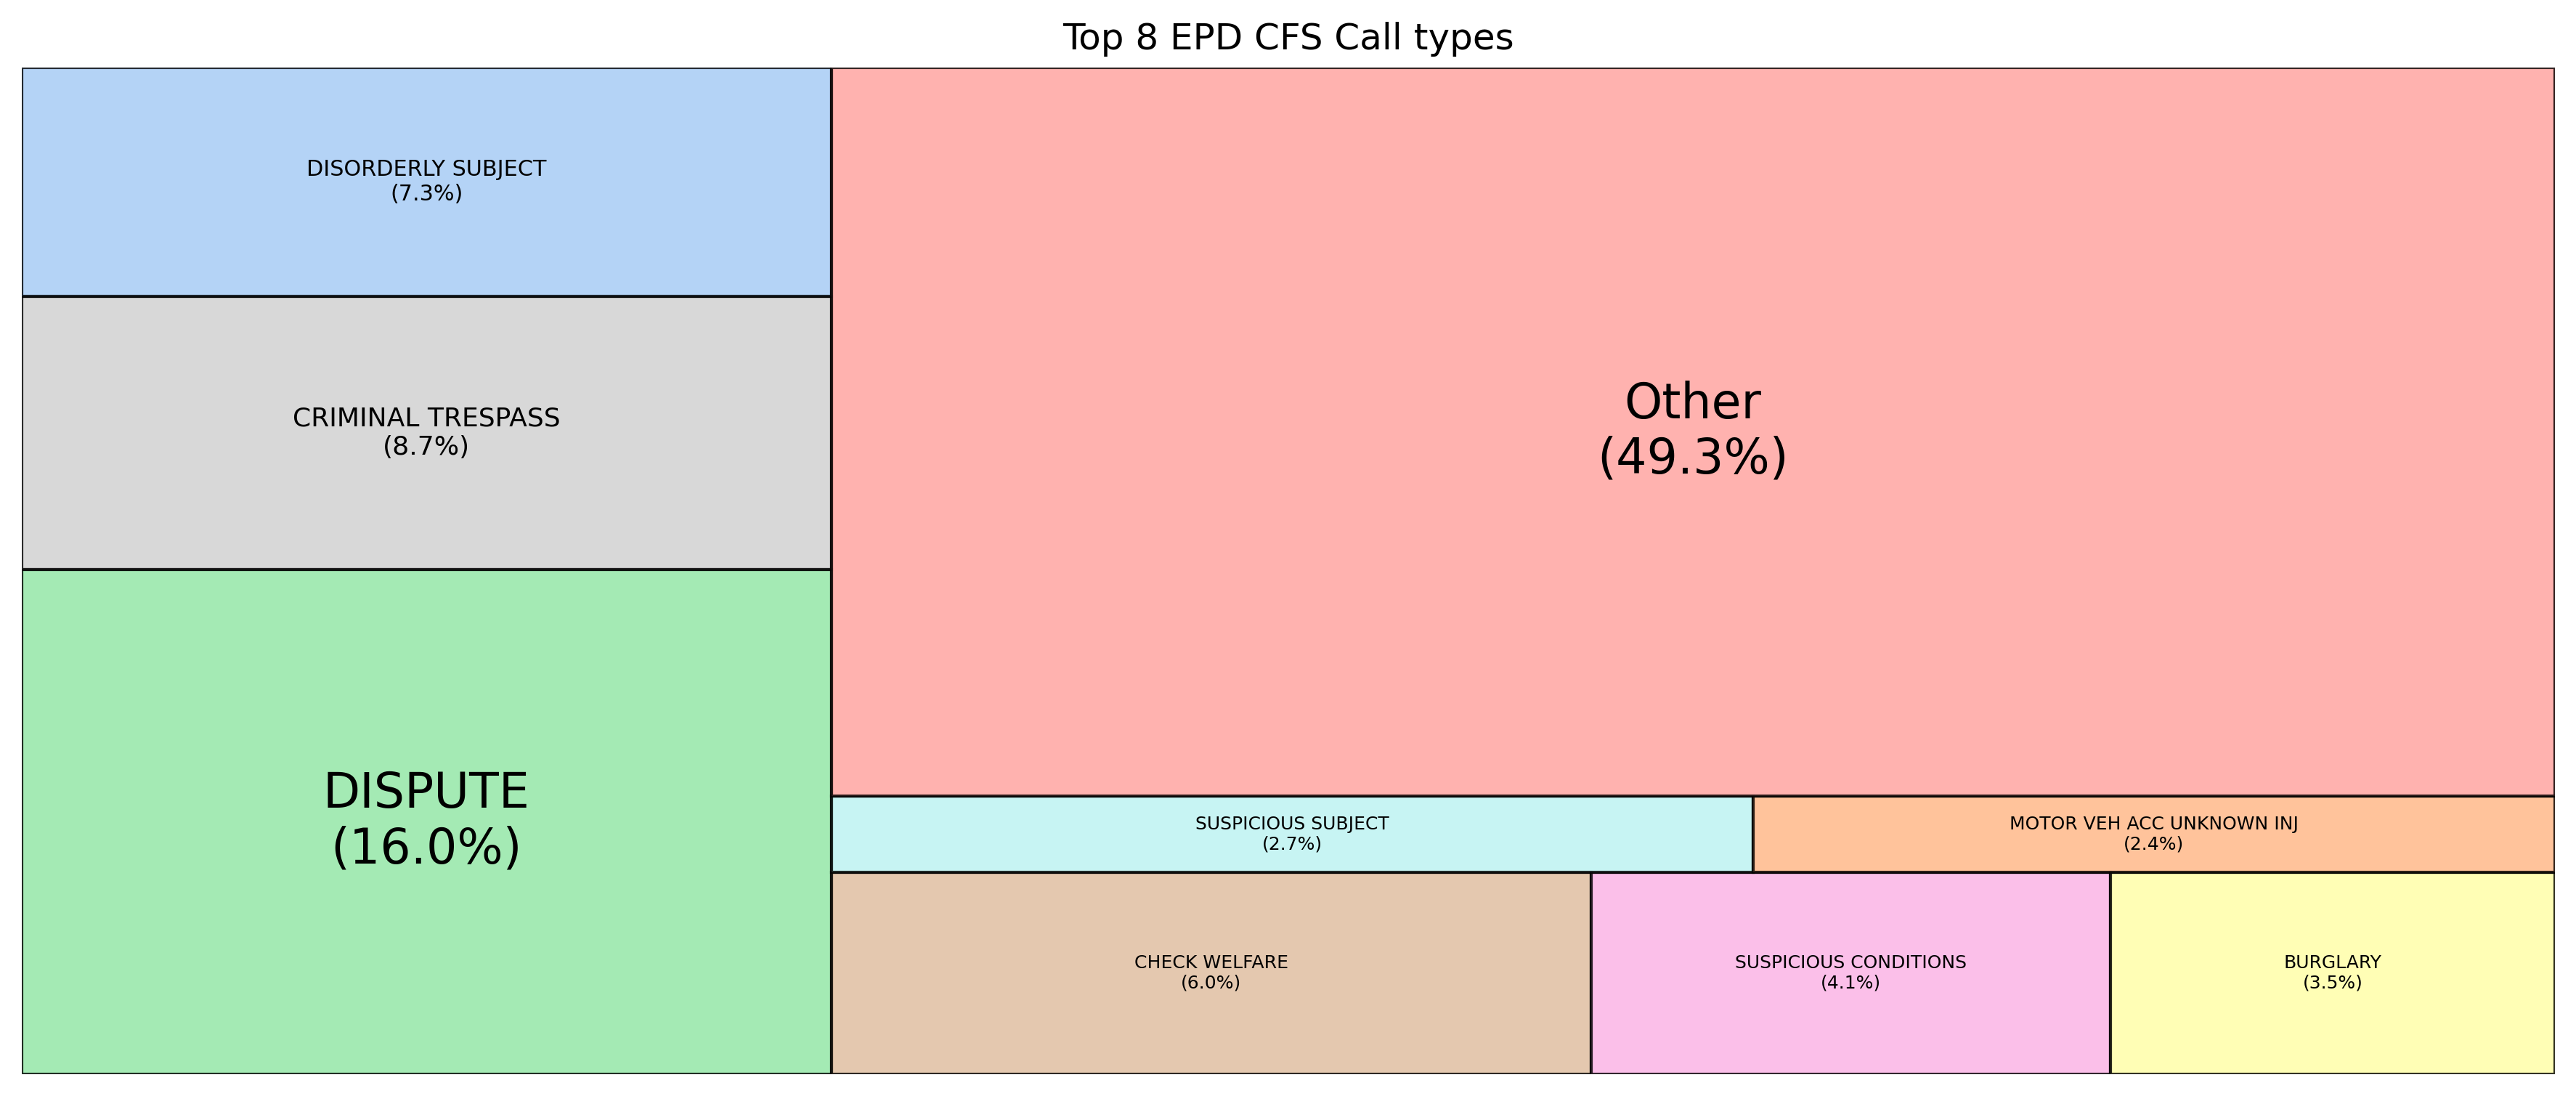

In [70]:
colors = sns.color_palette("pastel")
create_treemap(dataset_builder(input_data, dispatched=Dispatched, arrived=Arrived, time=time_range), Title, top_n=top_n_types, group_others=group_others, max_legend_entries=10, show_labels=show_labels, color_list=colors, min_label_area_ratio=0.01)

In [71]:
title = "Top 10 total CFS Call types"
top_n = 10
group_others = True


overlap_table = prop_table(CAD_data)
#color_list = plt.cm.Paired.colors
color_list = plt.get_cmap('tab20').colors


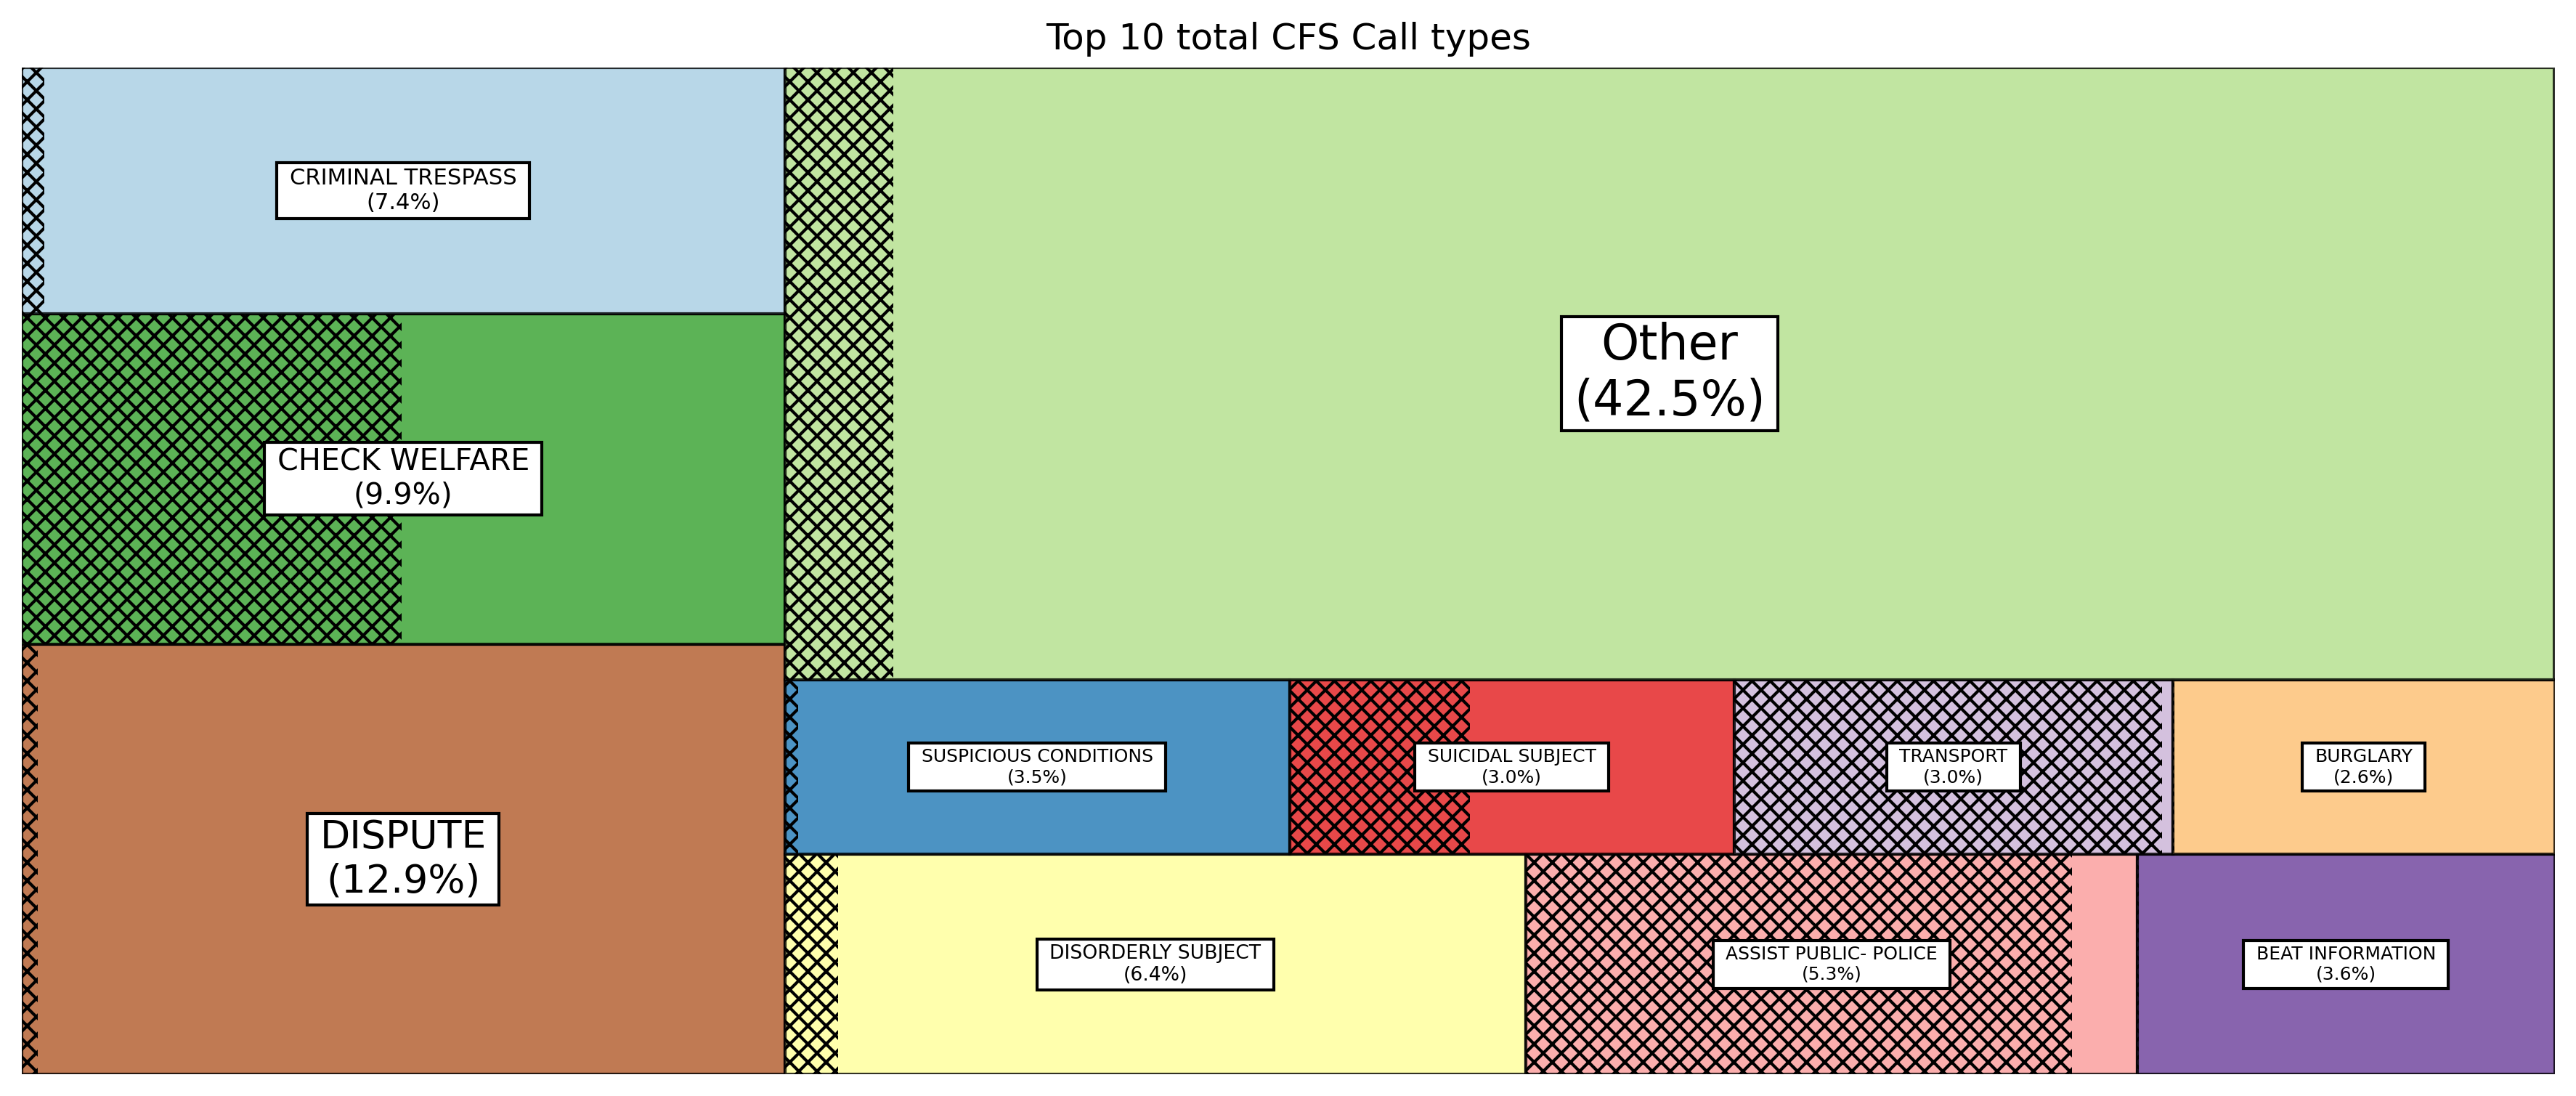

In [74]:
overlap_table = prop_table(CAD_data)
color_list = plt.cm.Paired.colors
create_treemap_adv(overlap_table, title=title, top_n=top_n, group_others=group_others, color_list=color_list , min_label_area_ratio=0.005)

# Diversion Rate Naming Scheme

**Diversion Rate Shorthand System**

This system provides a concise way to reference various diversion rates by combining two sets of codes:

1. **Call Type Inclusion Codes**: Indicate which call types are included in the calculation.
2. **Dispatch Status Codes**: Specify the numerator and denominator in terms of dispatch and arrival status.

---

### **Call Type Inclusion Codes**

- **UN**: **Unadjusted Diversion Rate**
  - *Includes all call types without exclusions.*

- **PM**: **Police Mandate Calls**
  - *Excludes the top three CAHOOTS call types: Welfare Check, Public Assist, Transportation.*

- **WC74**: **Welfare Checks at 74%**
  - *Includes 74% of welfare check calls, based on their estimated divertibility.*

- **PMWC74**: **Police Mandate Calls plus 74% Welfare Checks**
  - *Combines police mandate calls with 74% of welfare checks; excludes Public Assist and Transportation.*

---

### **Dispatch Status Codes**

Codes are written in the order `Numerator` `Denominator`:

- **T**: **Total Calls**
  - *All calls for service.*

- **D**: **Dispatched Calls**
  - *Calls where CAHOOTS or EPD were dispatched.*

- **A**: **Arrived Solo CAHOOTS**
  - *Calls where CAHOOTS arrived on scene and handled the call without assistance from other agencies.*

---

### **Combined Shorthand Codes**

Here are the codes for each diversion rate covered in the paper:

#### **Group 1: Unadjusted Diversion Rates (UN)**

- **UN - TT**
  - *Definition*: Total CAHOOTS calls (all types) divided by total calls.
  
- **UN - DT**
  - *Definition*: Dispatched CAHOOTS calls divided by total calls.

- **UN - AT**
  - *Definition*: Arrived solo CAHOOTS calls divided by total calls.

#### **Group 2: Police Mandate Calls (PM)**

- **PM - AT**
  - *Definition*: Arrived solo CAHOOTS (police mandate calls) divided by total calls.

- **PM - AD**
  - *Definition*: Arrived solo CAHOOTS (police mandate calls) divided by all dispatched calls.

#### **Group 3: 74% of Welfare Checks (WC74)**

- **WC74 - DT**
  - *Definition*: Dispatched CAHOOTS welfare check calls (×0.74) divided by total calls.

- **WC74 - DD**
  - *Definition*: Dispatched CAHOOTS welfare check calls (×0.74) divided by all dispatched calls.

#### **Group 4: Police Mandate Calls and 74% of Welfare Checks (PMWC74)**

- **PMWC74 - DT**
  - *Definition*: Dispatched CAHOOTS welfare check calls (excluding Public Assist, Transportation, and 26% of welfare checks) divided by total calls.

- **PMWC74 - DD**
  - *Definition*: Dispatched CAHOOTS welfare check calls (excluding Public Assist, Transportation, and 26% of welfare checks) divided by all dispatched calls.

---

### **Tables**

#### **Call Type Inclusion Codes**

| **Code**   | **Description**                                                                  |
|------------|----------------------------------------------------------------------------------|
| **UN**     | Unadjusted Diversion Rate (includes all call types)                              |
| **PM**     | Police Mandate Calls (excludes top 3 CAHOOTS call types)                         |
| **WC74**   | 74% of CAHOOTS Welfare Checks (includes only Welfare Check calls * 0.74)                           |
| **PMWC74** | Police Mandate Calls and 74% of Welfare Checks (PM calls + WC74)          |

#### **Dispatch Status Codes**

| **Code** | **Meaning**             |
|----------|-------------------------|
| **T**    | Total Calls             |
| **D**    | Dispatched Calls        |
| **A**    | Arrived Solo CAHOOTS    |

*Codes are combined in the order `Numerator` `Denominator`*

#### **Combined Shorthand Codes and Definitions**

| **Shorthand Code** | **Definition**                                                                                         |
|--------------------|--------------------------------------------------------------------------------------------------------|
| **UN - TT**        | Total CAHOOTS calls / Total calls                                                                      |
| **UN - DT**        | Dispatched CAHOOTS calls / Total calls                                                                 |
| **UN - AT**        | Arrived solo CAHOOTS calls / Total calls                                                               |
| **PM - AT**        | Arrived solo CAHOOTS (police mandate calls) / Total calls                                              |
| **PM - AD**        | Arrived solo CAHOOTS (police mandate calls) / All dispatched calls                                     |
| **WC74 - DT**      | Dispatched CAHOOTS welfare checks (×0.74) / Total calls                                               |
| **WC74 - DD**      | Dispatched CAHOOTS welfare checks (×0.74) / All dispatched calls                                      |
| **PMWC74 - DT**    | Dispatched CAHOOTS PM & WC74 calls / Total calls                                                        |
| **PMWC74 - DD**    | Dispatched CAHOOTS PM & WC74 calls / All dispatched calls                                               |

---
